In [3]:
# 定义一个句子列表，后面会用这些句子来训练 CBOW 和 Skip-Gram 模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]
# 将所有句子连接在一起，然后用空格分隔成多个单词
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到对应的词
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list)  # 计算词汇表的大小
print(" 词汇表：", word_list)  # 输出词汇表
print(" 词汇到索引的字典：", word_to_idx)  # 输出词汇到索引的字典
print(" 索引到词汇的字典：", idx_to_word)  # 输出索引到词汇的字典
print(" 词汇表大小：", voc_size)  # 输出词汇表大小

 词汇表： ['Kage', 'Teacher', 'Niuzong', 'Mazong', 'Student', 'Xiaoxue', 'Xiaobing', 'is', 'Boss']
 词汇到索引的字典： {'Kage': 0, 'Teacher': 1, 'Niuzong': 2, 'Mazong': 3, 'Student': 4, 'Xiaoxue': 5, 'Xiaobing': 6, 'is': 7, 'Boss': 8}
 索引到词汇的字典： {0: 'Kage', 1: 'Teacher', 2: 'Niuzong', 3: 'Mazong', 4: 'Student', 5: 'Xiaoxue', 6: 'Xiaobing', 7: 'is', 8: 'Boss'}
 词汇表大小： 9


In [4]:
# 生成 Skip-Gram 训练数据
def create_skipgram_dataset(sentences, window_size=2):
    data = []  # 初始化数据
    for sentence in sentences:  # 遍历句子
        sentence = sentence.split()  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取相邻的单词，将当前单词前后各 N 个单词作为相邻单词
            for neighbor in sentence[max(idx - window_size, 0):
                                     min(idx + window_size + 1, len(sentence))]:
                if neighbor != word:  # 排除当前单词本身
                    # 将相邻单词与当前单词作为一组训练数据
                    data.append((neighbor, word))
    return data


# 使用函数创建 Skip-Gram 训练数据
skipgram_data = create_skipgram_dataset(sentences)
# 打印未编码的 Skip-Gram 数据样例（前 3 个）
print("Skip-Gram 数据样例（未编码）：", skipgram_data[:3])

Skip-Gram 数据样例（未编码）： [('is', 'Kage'), ('Teacher', 'Kage'), ('Kage', 'is')]


In [5]:
# 定义 One-Hot 编码函数
import torch  # 导入 torch 库


def one_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(len(word_to_idx))  # 创建一个长度与词汇表相同的全 0 张量
    tensor[word_to_idx[word]] = 1  # 将对应词的索引设为 1
    return tensor  # 返回生成的 One-Hot 向量


# 展示 One-Hot 编码前后的数据
word_example = "Teacher"
print("One-Hot 编码前的单词：", word_example)
print("One-Hot 编码后的向量：", one_hot_encoding(word_example, word_to_idx))
# 展示编码后的 Skip-Gram 训练数据样例
print("Skip-Gram 数据样例（已编码）：", [(one_hot_encoding(context, word_to_idx),
                                word_to_idx[target]) for context, target in skipgram_data[:3]])

One-Hot 编码前的单词： Teacher
One-Hot 编码后的向量： tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.])
Skip-Gram 数据样例（已编码）： [(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.]), 0), (tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.]), 0), (tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 7)]


In [6]:
# 定义 Skip-Gram 类
import torch.nn as nn  # 导入 neural network


class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(SkipGram, self).__init__()
        # 从词汇表大小到嵌入层大小（维度）的线性层（权重矩阵）
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias=False)
        # 从嵌入层大小（维度）到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)

    def forward(self, X):  # 前向传播的方式，X 形状为 (batch_size, voc_size)
        # 通过隐藏层，hidden 形状为 (batch_size, embedding_size)
        hidden = self.input_to_hidden(X)
        # 通过输出层，output_layer 形状为 (batch_size, voc_size)
        output = self.hidden_to_output(hidden)
        return output


embedding_size = 2  # 设定嵌入层的大小，这里选择 2 是为了方便展示
skipgram_model = SkipGram(voc_size, embedding_size)  # 实例化 Skip-Gram 模型
print("Skip-Gram 模型：", skipgram_model)

Skip-Gram 模型： SkipGram(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


Epoch: 100, Loss: 1.6681423425674438
Epoch: 200, Loss: 1.6601408302783967
Epoch: 300, Loss: 1.6528828899065653
Epoch: 400, Loss: 1.6462927997112273
Epoch: 500, Loss: 1.6402994493643444
Epoch: 600, Loss: 1.6348367889722188
Epoch: 700, Loss: 1.6298452119032543
Epoch: 800, Loss: 1.6252705375353496
Epoch: 900, Loss: 1.6210647543271384
Epoch: 1000, Loss: 1.6171851913134256


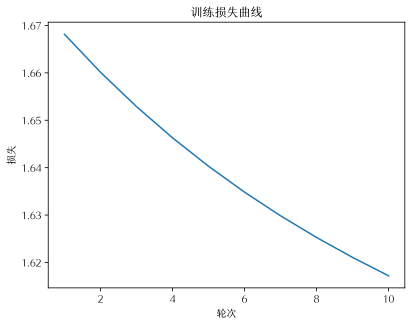

In [11]:
# 训练 Skip-Gram 类
import matplotlib.pyplot as plt  # 导入 matplotlib
import torch.optim as optim  # 导入随机梯度下降优化器
learning_rate = 0.001  # 设置学习速率
epochs = 1000  # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)
# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0  # 初始化损失值
    for context, target in skipgram_data:
        X = one_hot_encoding(target, word_to_idx).float(
        ).unsqueeze(0)  # 将中心词转换为 One-Hot 向量
        y_true = torch.tensor([word_to_idx[context]],
                              dtype=torch.long)  # 将周围词转换为索引值
        y_pred = skipgram_model(X)  # 计算预测值
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item()  # 累积损失
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch+1) % 100 == 0:  # 输出每 100 轮的损失，并记录损失
        print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(skipgram_data)}")
        loss_values.append(loss_sum / len(skipgram_data))
# 绘制训练损失曲线
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
# 绘制二维词向量图
plt.rcParams["font.family"] = ['HYYiSongW']  # 用来设定字体样式
plt.rcParams['font.sans-serif'] = ['HYYiSongW']  # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values)  # 绘图
plt.title(' 训练损失曲线 ')  # 图题
plt.xlabel(' 轮次 ')  # X 轴 Label
plt.ylabel(' 损失 ')  # Y 轴 Label
plt.show()  # 显示图

In [12]:
# 输出 Skip-Gram 习得的词嵌入
print("Skip-Gram 词嵌入：")
for word, idx in word_to_idx.items(): # 输出每个词的嵌入向量
 print(f"{word}: {skipgram_model.input_to_hidden.weight[:,idx].detach().numpy()}")

Skip-Gram 词嵌入：
Kage: [-1.3852506  0.8693504]
Teacher: [0.13351177 0.739873  ]
Niuzong: [0.18486483 0.7297219 ]
Mazong: [0.2506835 0.7392288]
Student: [0.74330455 0.8955775 ]
Xiaoxue: [1.551052  1.1234866]
Xiaobing: [1.4570289 1.0744089]
is: [ 0.32946107 -1.0518279 ]
Boss: [-1.6621883  0.9822063]


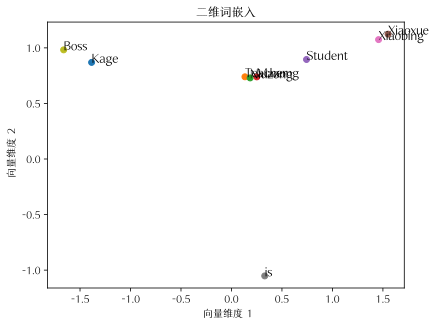

In [13]:
fig, ax = plt.subplots() 
for word, idx in word_to_idx.items():
    # 获取每个单词的嵌入向量
    vec = skipgram_model.input_to_hidden.weight[:,idx].detach().numpy() 
    ax.scatter(vec[0], vec[1]) # 在图中绘制嵌入向量的点
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 点旁添加单词标签
plt.title(' 二维词嵌入 ') # 图题
plt.xlabel(' 向量维度 1') # X 轴 Label
plt.ylabel(' 向量维度 2') # Y 轴 Label
plt.show() # 显示图

In [14]:
# 定义一个句子列表，后面会用这些句子来训练 CBOW 和 Skip-Gram 模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]
# 将所有句子连接在一起，然后用空格分隔成多个单词
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到对应的词
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list) # 计算词汇表的大小
print(" 词汇表：", word_list) # 输出词汇表
print(" 词汇到索引的字典：", word_to_idx) # 输出词汇到索引的字典
print(" 索引到词汇的字典：", idx_to_word) # 输出索引到词汇的字典
print(" 词汇表大小：", voc_size) # 输出词汇表大小

 词汇表： ['Kage', 'Teacher', 'Niuzong', 'Mazong', 'Student', 'Xiaoxue', 'Xiaobing', 'is', 'Boss']
 词汇到索引的字典： {'Kage': 0, 'Teacher': 1, 'Niuzong': 2, 'Mazong': 3, 'Student': 4, 'Xiaoxue': 5, 'Xiaobing': 6, 'is': 7, 'Boss': 8}
 索引到词汇的字典： {0: 'Kage', 1: 'Teacher', 2: 'Niuzong', 3: 'Mazong', 4: 'Student', 5: 'Xiaoxue', 6: 'Xiaobing', 7: 'is', 8: 'Boss'}
 词汇表大小： 9


In [15]:
# 生成 CBOW 训练数据
def create_cbow_dataset(sentences, window_size=2):
    data = []# 初始化数据
    for sentence in sentences:
        sentence = sentence.split()  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取上下文词汇，将当前单词前后各 window_size 个单词作为周围词
            context_words = sentence[max(idx - window_size, 0):idx] \
                + sentence[idx + 1:min(idx + window_size + 1, len(sentence))]
            # 将当前单词与上下文词汇作为一组训练数据
            data.append((word, context_words))
    return data
# 使用函数创建 CBOW 训练数据
cbow_data = create_cbow_dataset(sentences)
# 打印未编码的 CBOW 数据样例（前三个）
print("CBOW 数据样例（未编码）：", cbow_data[:3])

CBOW 数据样例（未编码）： [('Kage', ['is', 'Teacher']), ('is', ['Kage', 'Teacher']), ('Teacher', ['Kage', 'is'])]


In [16]:
# 定义 One-Hot 编码函数
import torch # 导入 torch 库
def one_hot_encoding(word, word_to_idx):    
    tensor = torch.zeros(len(word_to_idx)) # 创建一个长度与词汇表相同的全 0 张量  
    tensor[word_to_idx[word]] = 1  # 将对应词的索引设为 1
    return tensor  # 返回生成的 One-Hot 向量
# 展示 One-Hot 编码前后的数据
word_example = "Teacher"
print("One-Hot 编码前的单词：", word_example)
print("One-Hot 编码后的向量：", one_hot_encoding(word_example, word_to_idx))

One-Hot 编码前的单词： Teacher
One-Hot 编码后的向量： tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.])


In [17]:
# 定义 CBOW 模型
import torch.nn as nn # 导入 neural network
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(CBOW, self).__init__()
        # 从词汇表大小到嵌入大小的线性层（权重矩阵）
        self.input_to_hidden = nn.Linear(voc_size, 
                                         embedding_size, bias=False)  
        # 从嵌入大小到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(embedding_size, 
                                          voc_size, bias=False)  
    def forward(self, X): # X: [num_context_words, voc_size]
        # 生成嵌入：[num_context_words, embedding_size]
        embeddings = self.input_to_hidden(X)  
        # 计算隐藏层，求嵌入的均值：[embedding_size]
        hidden_layer = torch.mean(embeddings, dim=0)  
        # 生成输出层：[1, voc_size]
        output_layer = self.hidden_to_output(hidden_layer.unsqueeze(0)) 
        return output_layer    
embedding_size = 2 # 设定嵌入层的大小，这里选择 2 是为了方便展示
cbow_model = CBOW(voc_size,embedding_size)  # 实例化 CBOW 模型
print("CBOW 模型：", cbow_model)

CBOW 模型： CBOW(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


Epoch: 100, Loss: 2.1996248086293537
Epoch: 200, Loss: 2.188123941421509
Epoch: 300, Loss: 2.175392580032349
Epoch: 400, Loss: 2.1604762951533
Epoch: 500, Loss: 2.142255361874898
Epoch: 600, Loss: 2.119394294420878
Epoch: 700, Loss: 2.0903213818868003
Epoch: 800, Loss: 2.053282046318054
Epoch: 900, Loss: 2.006536682446798
Epoch: 1000, Loss: 1.9488139152526855


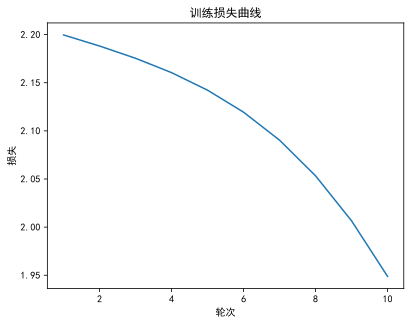

In [18]:
# 训练 Skip-Gram 类
learning_rate = 0.001 # 设置学习速率
epochs = 1000 # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
import torch.optim as optim # 导入随机梯度下降优化器
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)  
# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0 # 初始化损失值
    for target, context_words in cbow_data:
        # 将上下文词转换为 One-Hot 向量并堆叠
        X = torch.stack([one_hot_encoding(word, word_to_idx) for word in context_words]).float() 
        # 将目标词转换为索引值
        y_true = torch.tensor([word_to_idx[target]], dtype=torch.long) 
        y_pred = cbow_model(X)  # 计算预测值
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item() # 累积损失
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch+1) % 100 == 0: # 输出每 100 轮的损失，并记录损失
      print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(cbow_data)}")  
      loss_values.append(loss_sum / len(cbow_data))
# 绘制训练损失曲线
import matplotlib.pyplot as plt # 导入 matplotlib
# 绘制二维词向量图
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title(' 训练损失曲线 ') # 图题
plt.xlabel(' 轮次 ') # X 轴 Label
plt.ylabel(' 损失 ') # Y 轴 Label
plt.show() # 显示图

In [19]:
# 输出 Skip-Gram 习得的词嵌入
print("Skip-Gram 词嵌入：")
for word, idx in word_to_idx.items(): # 输出每个词的嵌入向量
 print(f"{word}: {cbow_model.input_to_hidden.weight[:,idx].detach().numpy()}")

Skip-Gram 词嵌入：
Kage: [-0.3498569  0.3470207]
Teacher: [ 0.22911373 -0.00054831]
Niuzong: [0.03256042 0.42107108]
Mazong: [0.05406316 0.34947005]
Student: [0.35608625 0.94928825]
Xiaoxue: [0.19755979 0.08676014]
Xiaobing: [-0.11371389  0.35866714]
is: [-0.57964087 -0.48804438]
Boss: [0.13130373 0.6148729 ]


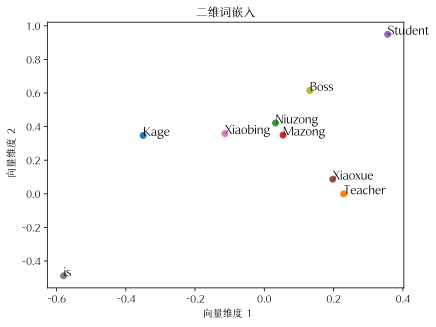

In [24]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
# 绘制二维词向量图
plt.rcParams["font.family"] = ['HYYiSongW']  # 用来设定字体样式
plt.rcParams['font.sans-serif'] = ['HYYiSongW']  # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
fig, ax = plt.subplots() 
for word, idx in word_to_idx.items():
    # 获取每个单词的嵌入向量
    vec = cbow_model.input_to_hidden.weight[:,idx].detach().numpy() 
    ax.scatter(vec[0], vec[1]) # 在图中绘制嵌入向量的点
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 点旁添加单词标签
plt.title(' 二维词嵌入 ') # 图题
plt.xlabel(' 向量维度 1') # X 轴 Label
plt.ylabel(' 向量维度 2') # Y 轴 Label
plt.show() # 显示图

In [25]:
# 定义一个句子列表，后面会用这些句子来训练 CBOW 和 Skip-Gram 模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]
# 将所有句子连接在一起，然后用空格分隔成多个单词
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到对应的词
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list) # 计算词汇表的大小
print(" 词汇表：", word_list) # 输出词汇表
print(" 词汇到索引的字典：", word_to_idx) # 输出词汇到索引的字典
print(" 索引到词汇的字典：", idx_to_word) # 输出索引到词汇的字典
print(" 词汇表大小：", voc_size) # 输出词汇表大小

 词汇表： ['Kage', 'Teacher', 'Niuzong', 'Mazong', 'Student', 'Xiaoxue', 'Xiaobing', 'is', 'Boss']
 词汇到索引的字典： {'Kage': 0, 'Teacher': 1, 'Niuzong': 2, 'Mazong': 3, 'Student': 4, 'Xiaoxue': 5, 'Xiaobing': 6, 'is': 7, 'Boss': 8}
 索引到词汇的字典： {0: 'Kage', 1: 'Teacher', 2: 'Niuzong', 3: 'Mazong', 4: 'Student', 5: 'Xiaoxue', 6: 'Xiaobing', 7: 'is', 8: 'Boss'}
 词汇表大小： 9


In [26]:
# 生成 Skip-Gram 训练数据
def create_skipgram_dataset(sentences, window_size=2):
    data = [] # 初始化数据
    for sentence in sentences: # 遍历句子
        sentence = sentence.split()  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取相邻的单词，将当前单词前后各 N 个单词作为相邻单词
            for neighbor in sentence[max(idx - window_size, 0): 
                        min(idx + window_size + 1, len(sentence))]:
                if neighbor != word:  # 排除当前单词本身
                    # 将相邻单词与当前单词作为一组训练数据
                    data.append((neighbor, word))
    return data
# 使用函数创建 Skip-Gram 训练数据
skipgram_data = create_skipgram_dataset(sentences)
# 打印未编码的 Skip-Gram 数据样例（前 3 个）
print("Skip-Gram 数据样例（未编码）：", skipgram_data[:3])

Skip-Gram 数据样例（未编码）： [('is', 'Kage'), ('Teacher', 'Kage'), ('Kage', 'is')]


In [27]:
# 定义 One-Hot 编码函数
import torch # 导入 torch 库
def one_hot_encoding(word, word_to_idx):    
    tensor = torch.zeros(len(word_to_idx)) # 创建一个长度与词汇表相同的全 0 张量  
    tensor[word_to_idx[word]] = 1  # 将对应词的索引设为 1
    return tensor  # 返回生成的 One-Hot 向量
# 展示 One-Hot 编码前后的数据
word_example = "Teacher"
print("One-Hot 编码前的单词：", word_example)
print("One-Hot 编码后的向量：", one_hot_encoding(word_example, word_to_idx))
# 展示编码后的 Skip-Gram 训练数据样例
print("Skip-Gram 数据样例（已编码）：", [(one_hot_encoding(context, word_to_idx), 
          word_to_idx[target]) for context, target in skipgram_data[:3]])

One-Hot 编码前的单词： Teacher
One-Hot 编码后的向量： tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.])
Skip-Gram 数据样例（已编码）： [(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.]), 0), (tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.]), 0), (tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 7)]


In [28]:
# 定义 Skip-Gram 模型
import torch.nn as nn # 导入 neural network
class SkipGram(nn.Module):
 def __init__(self, voc_size, embedding_size):
    super(SkipGram, self).__init__()
    # 从词汇表大小到嵌入大小的嵌入层（权重矩阵）
    self.input_to_hidden = nn.Embedding(voc_size, embedding_size)  
    # 从嵌入大小到词汇表大小的线性层（权重矩阵）
    self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False) 
 def forward(self, X):
    hidden_layer = self.input_to_hidden(X)  # 生成隐藏层：[batch_size, embedding_size]
    output_layer = self.hidden_to_output(hidden_layer)  # 生成输出层：[batch_size, voc_size]
    return output_layer  
embedding_size = 2 # 设定嵌入层的大小，这里选择 2 是为了方便展示
skipgram_model = SkipGram(voc_size, embedding_size)  # 实例化 Skip-Gram 模型
print("Skip-Gram 模型：", skipgram_model)

Skip-Gram 模型： SkipGram(
  (input_to_hidden): Embedding(9, 2)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


Epoch: 100, Loss: 2.0511016527811687
Epoch: 200, Loss: 1.9959393421808878
Epoch: 300, Loss: 1.954093603293101
Epoch: 400, Loss: 1.9165838221708933
Epoch: 500, Loss: 1.8806398024161657
Epoch: 600, Loss: 1.8452120820681255
Epoch: 700, Loss: 1.8099249343077342
Epoch: 800, Loss: 1.7754125823577245
Epoch: 900, Loss: 1.7434975375731787
Epoch: 1000, Loss: 1.7161492149035136


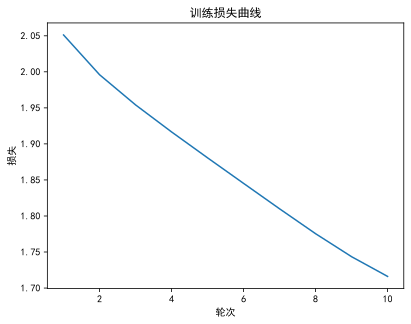

In [29]:
# 训练 Skip-Gram 类
learning_rate = 0.001 # 设置学习速率
epochs = 1000 # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
import torch.optim as optim # 导入随机梯度下降优化器
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)  
# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0 # 初始化损失值
    for context, target in skipgram_data:        
        X = torch.tensor([word_to_idx[target]], dtype=torch.long)  # # 输入是中心词
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long)  # 目标词是周围词
        y_pred = skipgram_model(X)  # 计算预测值
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item() # 累积损失
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch+1) % 100 == 0: # 输出每 100 轮的损失，并记录损失
      print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(skipgram_data)}")  
      loss_values.append(loss_sum / len(skipgram_data))
# 绘制训练损失曲线
import matplotlib.pyplot as plt # 导入 matplotlib
# 绘制二维词向量图
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title(' 训练损失曲线 ') # 图题
plt.xlabel(' 轮次 ') # X 轴 Label
plt.ylabel(' 损失 ') # Y 轴 Label
plt.show() # 显示图

In [30]:
# 输出 Skip-Gram 习得的词嵌入
print("Skip-Gram 词嵌入：")
for word, idx in word_to_idx.items(): # 输出每个词的嵌入向量
 print(f"{word}: {skipgram_model.input_to_hidden.weight[idx].detach().numpy()}")

Skip-Gram 词嵌入：
Kage: [ 1.2614655  -0.44540745]
Teacher: [ 0.48368254 -0.69248414]
Niuzong: [0.81839806 0.6516823 ]
Mazong: [0.72978413 2.0010328 ]
Student: [1.3439869 0.9011428]
Xiaoxue: [0.5855849 1.2661027]
Xiaobing: [0.26253405 2.1544306 ]
is: [-0.6042532   0.13313057]
Boss: [ 1.3692567 -1.1711055]


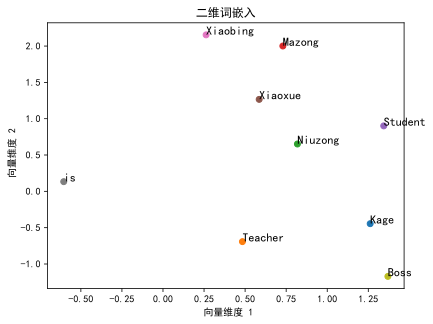

In [31]:
# 绘制二维词向量图
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
fig, ax = plt.subplots() 
for word, idx in word_to_idx.items():
    # 获取每个单词的嵌入向量
    vec = skipgram_model.input_to_hidden.weight[idx].detach().numpy() 
    ax.scatter(vec[0], vec[1]) # 在图中绘制嵌入向量的点
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 点旁添加单词标签
plt.title(' 二维词嵌入 ') # 图题
plt.xlabel(' 向量维度 1') # X 轴 Label
plt.ylabel(' 向量维度 2') # Y 轴 Label
plt.show() # 显示图